Si proverà in questo notebook a fare il fine tuning del summarizer con torch

In [4]:
!pip install transformers -U

  Using cached transformers-4.16.2-py3-none-any.whl (3.5 MB)
  Using cached requests-2.27.1-py2.py3-none-any.whl (63 kB)
  Using cached sacremoses-0.0.47-py2.py3-none-any.whl (895 kB)
  Using cached PyYAML-6.0-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (701 kB)
  Using cached huggingface_hub-0.4.0-py3-none-any.whl (67 kB)
  Using cached tqdm-4.62.3-py2.py3-none-any.whl (76 kB)
  Using cached filelock-3.4.2-py3-none-any.whl (9.9 kB)
  Using cached regex-2022.1.18-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (764 kB)
  Using cached tokenizers-0.11.4-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (6.8 MB)
  Using cached idna-3.3-py3-none-any.whl (61 kB)
  Using cached certifi-2021.10.8-py2.py3-none-any.whl (149 kB)
  Using cached urllib3-1.26.8-py2.py3-none-any.whl (138 kB)
  Using cached charset_normalizer-2.0.11-py3-none-any.whl (39 kB)


In [1]:
import numpy as np
import pandas as pd
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [2]:
train = pd.read_json('dialogsum.train.jsonl', lines= True)
train.head()

,fname,dialogue,summary,topic
0,train_0,"#Person1#: Hi, Mr. Smith. I'm Doctor Hawkins. ...","Mr. Smith's getting a check-up, and Doctor Haw...",get a check-up
1,train_1,"#Person1#: Hello Mrs. Parker, how have you bee...",Mrs Parker takes Ricky for his vaccines. Dr. P...,vaccines
2,train_2,"#Person1#: Excuse me, did you see a set of key...",#Person1#'s looking for a set of keys and asks...,find keys
3,train_3,#Person1#: Why didn't you tell me you had a gi...,#Person1#'s angry because #Person2# didn't tel...,have a girlfriend
4,train_4,"#Person1#: Watsup, ladies! Y'll looking'fine t...",Malik invites Nikki to dance. Nikki agrees if ...,dance


In [3]:
train.shape

(12460, 4)

In [4]:
# per il tokenizer di t5 c'è bisogno di sentence piece
!pip install sentencepiece

In [5]:
#tokenizer di t5
tokenizer = T5Tokenizer.from_pretrained('t5-base')

In [6]:
#preparo la lista dei dialoghi di train
train_list = ['summarize:' + item for item in train['dialogue'].tolist()]
train_list[:3]

["summarize:#Person1#: Hi, Mr. Smith. I'm Doctor Hawkins. Why are you here today?\n#Person2#: I found it would be a good idea to get a check-up.\n#Person1#: Yes, well, you haven't had one for 5 years. You should have one every year.\n#Person2#: I know. I figure as long as there is nothing wrong, why go see the doctor?\n#Person1#: Well, the best way to avoid serious illnesses is to find out about them early. So try to come at least once a year for your own good.\n#Person2#: Ok.\n#Person1#: Let me see here. Your eyes and ears look fine. Take a deep breath, please. Do you smoke, Mr. Smith?\n#Person2#: Yes.\n#Person1#: Smoking is the leading cause of lung cancer and heart disease, you know. You really should quit.\n#Person2#: I've tried hundreds of times, but I just can't seem to kick the habit.\n#Person1#: Well, we have classes and some medications that might help. I'll give you more information before you leave.\n#Person2#: Ok, thanks doctor.",
 "summarize:#Person1#: Hello Mrs. Parker, h

In [7]:
train_tensor = tokenizer(train_list, max_length= 512,return_tensors= 'pt', truncation= True, padding= True)
train_tensor #ok, ora abbiamo i tensori torch

{'input_ids': tensor([[21603,    10,  4663,  ...,     0,     0,     0],
        [21603,    10,  4663,  ...,     0,     0,     0],
        [21603,    10,  4663,  ...,     0,     0,     0],
        ...,
        [21603,    10,  4663,  ...,     0,     0,     0],
        [21603,    10,  4663,  ...,     0,     0,     0],
        [21603,    10,  4663,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [8]:
#estraggo indici e attention mask
train_ids = train_tensor['input_ids']
train_mask = train_tensor['attention_mask']

In [9]:
#stessa cosa per la label
with tokenizer.as_target_tokenizer():
        labels_train = tokenizer(train["summary"].tolist(), max_length=128, truncation=True, padding= True,return_tensors= 'pt')

In [10]:
labels_ids_train = labels_train.input_ids
labels_mask_train = labels_train.attention_mask

In [11]:
#assemlo i 4 elementi in un dataset torch: lo si passerà poi al dataloader per generare i batch
train_dataset = TensorDataset(train_ids, labels_ids_train, train_mask, labels_mask_train)

In [12]:
train_dataset

In [13]:
train_loader = DataLoader(train_dataset,batch_size= 4, shuffle= True)

In [13]:
for input_ids, labels_ids, input_mask, labels_mask in train_loader:
    print(input_ids, input_mask) #ok, ho i batches del mio dataset nell'ordine in cui li ho dati al tensor dataset

tensor([[21603,    10,  4663,  ...,     0,     0,     0],
        [21603,    10,  4663,  ...,     0,     0,     0],
        [21603,    10,  4663,  ...,     0,     0,     0],
        [21603,    10,  4663,  ...,     0,     0,     0]]) tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
tensor([[21603,    10,  4663,  ...,     0,     0,     0],
        [21603,    10,  4663,  ...,     0,     0,     0],
        [21603,    10,  4663,  ...,     0,     0,     0],
        [21603,    10,  4663,  ...,     0,     0,     0]]) tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
tensor([[21603,    10,  4663,  ...,     0,     0,     0],
        [21603,    10,  4663,  ...,     0,     0,     0],
        [21603,    10,  4663,  ...,     0,     0,     0],
        [21603,    10,  4663,  ...,     0,     0,     0]]) tensor([[1, 1, 1,  ..., 0, 

In [14]:
#inizializzo il modello
if torch.cuda.is_available:
    device = 'cuda'

else: 
    device = 'cpu'

print(device)

cuda


In [25]:
#inizializzo il modello
model = T5ForConditionalGeneration.from_pretrained('t5-base').to(device)
print(model.device)

cuda:0


In [16]:
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 2e-3, 
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  )

In [27]:
EPOCHS = 1
train_loss = []
for input_ids, labels_ids, input_mask, labels_mask in train_loader:
    input_ids = input_ids.to(device)
    labels_ids = labels_ids.to(device)
    input_mask = input_mask.to(device)
    labels_mask = labels_mask.to(device)

In [28]:
print(input_ids.device)

cuda:0


In [29]:
EPOCHS = 1
train_loss = []
for input_ids, labels_ids, input_mask, labels_mask in train_loader:
    #aggiungo i batches alla gpu
   input_ids = input_ids.to(device)
   labels_ids = labels_ids.to(device)
   input_mask = input_mask.to(device)
   labels_mask = labels_mask.to(device)
    
   #porto a -100 gli id della che hanno un attention mask pari a 0
   labels_ids[labels_ids == tokenizer.pad_token_id] = -100

    # azzero il gradiente
   optimizer.zero_grad()
    # Forward propagation
   outputs = model(input_ids, attention_mask= input_mask, labels=labels_ids)
   loss = outputs['loss']
   train_loss.append(loss.item())    

    # Backward pass
   loss.backward()
    # Update dei parametri
   optimizer.step()
    

In [30]:
len(train_loss) #si trova; la batch size è di 4 e la dimensione dell'input era più di 12000

3115

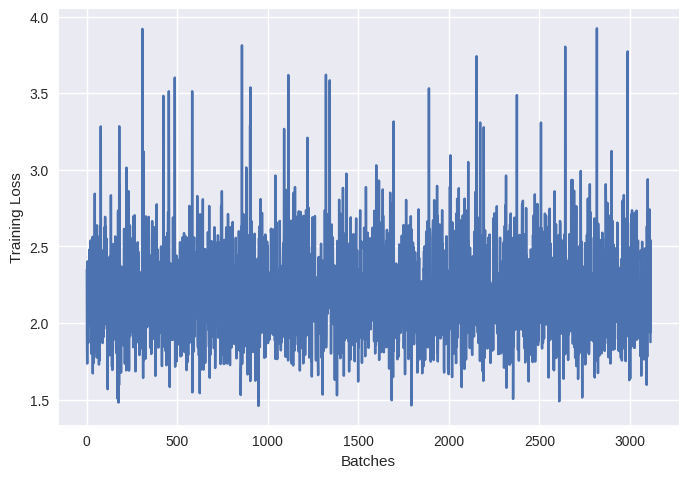

In [31]:
plt.subplots(dpi = 100)
plt.plot(train_loss)
plt.xlabel('Batches')
plt.ylabel('Training Loss')
plt.show()